In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from jmetal.core.algorithm import Algorithm
from jmetal.core.quality_indicator import *
from jmetal.util.solution import print_function_values_to_file, print_variables_to_file, read_solutions

# Create csv

In [2]:
def generate_summary_from_experiment(input_dir, quality_indicators, problems, evaluations,
                                     reference_fronts = ''):
    reference_change = 2500
    ref_time = 1
    if not quality_indicators:
        quality_indicators = []
        
    with open('QualityIndicatorSummary.csv', 'w+') as of:
        of.write('Algorithm,Problem,ExecutionId,Evaluations,IndicatorName,IndicatorValue\n')

    for dirname, _, filenames in os.walk(input_dir):
        print(dirname)
        for filename in sorted(filenames):
            try:
                # Linux filesystem
                algorithm, problem = dirname.split('/')[-2:]
            except ValueError:
                # Windows filesystem
                algorithm, problem = dirname.split('\\')[-2:]

            for problem_name in problems:
                if 'FUN' in filename and problem == problem_name:
                    solutions = read_solutions(os.path.join(dirname, filename))
                    digits = [s for s in filename.split('.') if s.isdigit()]
                    run_tag = digits[0]
                    evaluation_tag = evaluations
                    if len(digits) > 1:
                        evaluation_tag = digits[1]

                    for indicator in quality_indicators:
                        ref_time = min(int(int(evaluation_tag)/reference_change) + 1, 40)
                        reference_front_file = "resources/reference_front/{}_time{}.pf".format(problem_name, ref_time) 
  
                        # Add reference front if any
                        if hasattr(indicator, 'reference_front'):
                            if Path(reference_front_file).is_file():
                                reference_front = []
                                with open(reference_front_file) as file:
                                    for line in file:
                                        reference_front.append([float(x) for x in line.split()])

                                indicator.reference_front = reference_front
                            elif Path("resources/reference_front/{}.pf".format(problem_name)).is_file():
                                reference_front = []
                                with open("resources/reference_front/{}.pf".format(problem_name)) as file:
                                    for line in file:
                                        reference_front.append([float(x) for x in line.split()])

                                indicator.reference_front = reference_front
                            else:
                                print("no reference front for {}".format(problem))

                        result = indicator.compute([solutions[i].objectives for i in range(len(solutions))])

                        # Save quality indicator value to file
                        with open('QualityIndicatorSummary.csv', 'a+') as of:
                            of.write(','.join([algorithm, problem, str(run_tag), str(evaluation_tag), indicator.get_short_name(), str(result)]))
                            of.write('\n')

In [3]:
problems_cdf = ["CDF1", "CDF2", "CDF3", "CDF4", "CDF5", "CDF6", "CDF7", "CDF8",
            "CDF9", "CDF10", "CDF11", "CDF12", "CDF13", "CDF14", "CDF15"]
problems_udf = ["UDF1", "UDF2", "UDF3", "UDF4", "UDF5", "UDF6", "UDF8"]
problems_jy = ["JY1", "JY2", "JY3", "JY5", "JY6", "JY7", "JY8"]
problems_fda = ["FDA1", "FDA2", "FDA3"]
problems_static = ["ZDT1", "ZDT2", "ZDT3", "ZDT4", "ZDT6",
                  "WFG1", "WFG2", "WFG3", "WFG4", "WFG5", "WFG6", "WFG7", "WFG8", "WFG9",
                  "UF1", "UF2", "UF3", "UF4", "UF6", "UF7", "UF8", "UF9", "UF10",
                  "IMB1", "IMB2", "IMB3", "IMB4", "IMB6", "IMB7", "IMB8", "IMB9", "IMB10"
                  ]

In [5]:
output_directory = "data-500pop-100000evals-20runs-"

#generate_summary_from_experiment(output_directory, [InvertedGenerationalDistance(None)], 
#                                 problems_udf + problems_jy, 100000)

# Create dataframe

In [6]:
df = pd.read_csv("QualityIndicatorSummary.csv")

In [7]:
def get_average_igd(df, algorithms, problems, evaluations):
    igd_df = pd.DataFrame(columns=["Problem", "Evaluations"] + [a for a in algorithms])
    for p in problems:
        for e in evaluations:
            row = {
                "Problem": p
            }
            row["Evaluations"] = pd.to_numeric(e)

            for a in algorithms:
                igds = df[(df["Algorithm"] == a) & (df["Problem"] == p) & (df["Evaluations"] == e)]["IndicatorValue"]
                row[a] = np.average(igds)

            igd_df = igd_df.append(row, ignore_index=True)
    
    igd_df["Evaluations"] = pd.to_numeric(igd_df["Evaluations"])
    return igd_df

def get_difference(df, algorithm1, algorithm2):
    diff = []

    for p in df["Problem"].unique():
        for e in df["Evaluations"].unique():
            ag1 = df[(df["Problem"] == p) & (df["Evaluations"] == e)][algorithm1]
            ag2 = df[(df["Problem"] == p) & (df["Evaluations"] == e)][algorithm2]

            diff.append(float(ag1 - ag2))

    return diff

In [8]:
igd_df = get_average_igd(df, 
                         ["MOEAD", "MOEAD-e", "MOEAD-e-ib", "MOEAD-e-ip"], 
                         problems_udf + problems_jy, 
                         [i for i in range(1000, 101000, 1000)]
                        )

### Calculate difference

In [9]:
diff_e = get_difference(igd_df, "MOEAD", "MOEAD-e")
diff_b = get_difference(igd_df, "MOEAD", "MOEAD-e-ib")
diff_p = get_difference(igd_df, "MOEAD", "MOEAD-e-ip")

# store diff in df
igd_df["Diff-e"] = diff_e
igd_df["Diff-b"] = diff_b
igd_df["Diff-p"] = diff_p

# calculate % difference
igd_df["Diff-e %"] = igd_df["Diff-e"] / igd_df["MOEAD"] * 100
igd_df["Diff-b %"] = igd_df["Diff-b"] / igd_df["MOEAD"] * 100
igd_df["Diff-p %"] = igd_df["Diff-p"] / igd_df["MOEAD"] * 100

# Create visualisations

In [10]:
def plot_difference(df, plot_names, problems):
    for p in problems:
        fig, axes = plt.subplots(1, len(plot_names), figsize=(18,5), sharex=True)
        
        plot_df = df[(df["Problem"] == p)]
        i = 0
        ymin = 0
        ymax = 0
        for plot in plot_names:
            plot_background(axes[i])

            #plot
            plot_df.plot(
                x="Evaluations", y=plot, kind="scatter",
                title="{} IGD difference".format(p),
                color=np.where(plot_df[plot] > 0, 'b', 'r'),
                # same axes on y
                ax=axes[i]
            )
            
            miny = min(plot_df[plot])
            maxy = max(plot_df[plot])
            if miny < ymin: ymin = miny
            if maxy > ymax: ymax = maxy
            i += 1

        for ax in axes:
            ax.set_ylim(ymin-2, ymax+2)
            
def plot_scatter(df, plot_names, problems):
    for p in problems:
        fig, axes = plt.subplots(1, len(plot_names), figsize=(18,5))
        
        i = 0
        for plot in plot_names:
            plot_background(axes[i])
            
            igd_df[(igd_df["Problem"] == p)].plot(
                x="Evaluations", y="MOEAD", kind="scatter",
                title="{} IGD".format(p),
                color='b',
                ax=axes[i]
            )
            igd_df[(igd_df["Problem"] == p)].plot(
                x="Evaluations", y=plot, kind="scatter",
                title="{} IGD".format(p),
                color='r',
                ax=axes[i]
            )
            i += 1
            
def plot_background(ax):
    for j in range(0, 100000, 50000):
        ax.axvspan(j, j+25000, facecolor='grey', alpha=0.2)

In [11]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

def create_patch(ax, wedges, problems):
    groups=[[i,i+1] for i in range(0, len(problems)*2, 2)]
    radfraction = 0.1
    patches = []


    for i, problem in zip(groups, problems):
        ang = np.deg2rad((wedges[i[-1]].theta2 + wedges[i[0]].theta1)/2,)
        for j in i:
            we = wedges[j]
            center = (radfraction*we.r*np.cos(ang), radfraction*we.r*np.sin(ang))
            patches.append(mpatches.Wedge(center, we.r, we.theta1, we.theta2))

        text_ang = np.deg2rad((wedges[i[-1]].theta1 + wedges[i[0]].theta2)/2,)
        ax.text(radfraction*((wedges[i[0]].r+wedges[i[1]].r)/2)*np.cos(text_ang)*12, 
                radfraction*((wedges[i[0]].r+wedges[i[1]].r)/2)*np.sin(text_ang)*12, problem)

    collection = PatchCollection(patches, facecolors=['skyblue', 'crimson'])
    return collection

def create_pie(df, plotnames, problems):
    fig, axes = plt.subplots(1, len(plotnames), figsize=(18,7))
    for plotname, i in zip(plotnames, range(len(plotnames))):
        area = calculate_area(igd_df, plotname, problems)

        fig,ax = plt.subplots(1,2)
        wedges, texts = ax[0].pie(area, startangle=90, counterclock=False)
        plt.close()

        collection = create_patch(axes[i], wedges, problems)
        axes[i].set_aspect('equal')
        axes[i].axis('off')
        axes[i].add_collection(collection)
        axes[i].autoscale(True)
        axes[i].set_title("Area under " + plotname, pad=30)

In [12]:
def calculate_area(df, diff_column, problems):
    problem_areas = []
    for p in problems:
        
        diffs = df[(df["Problem"] == p)][diff_column].tolist()
        pos = np.trapz(list(filter(lambda x: x > 0, diffs)), dx=1)
        neg = np.trapz(list(filter(lambda x: x < 0, diffs)), dx=1)
        
        problem_areas.append(pos)
        problem_areas.append(abs(neg))

    return problem_areas

In [13]:
def plot_pf(problem):
    pf = pd.read_csv("resources/reference_front/{}_time1.pf".format(problem), delimiter = "\t")
    pf2 = pd.read_csv("resources/reference_front/{}_time4.pf".format(problem), delimiter = "\t")
    pf3 = pd.read_csv("resources/reference_front/{}_time8.pf".format(problem), delimiter = "\t")
    
    ax1 = pf.plot.scatter(x=0, y=1)
    ax2 = pf2.plot.scatter(x=0, y=1, ax=ax1)
    ax3 = pf3.plot.scatter(x=0, y=1, ax=ax1)

In [19]:
def plot_all(df, problems):
    plot_difference(df, ["Diff-e %", "Diff-b %", "Diff-p %"], problems)
    plot_scatter(df, ["MOEAD-e", "MOEAD-e-ib", "MOEAD-e-ip"], problems)
    create_pie(df, ["Diff-e %", "Diff-b %", "Diff-p %"], problems)

In [20]:
#pof change
diagonal_shift = ["UDF1", "UDF2", "UDF3", "UDF6"]
angular_shift = ["UDF4", "UDF6", "JY2", "JY3", "JY5", "JY7", "JY8"]

#pos change
vertical_shift = ["JY1", "JY6"]

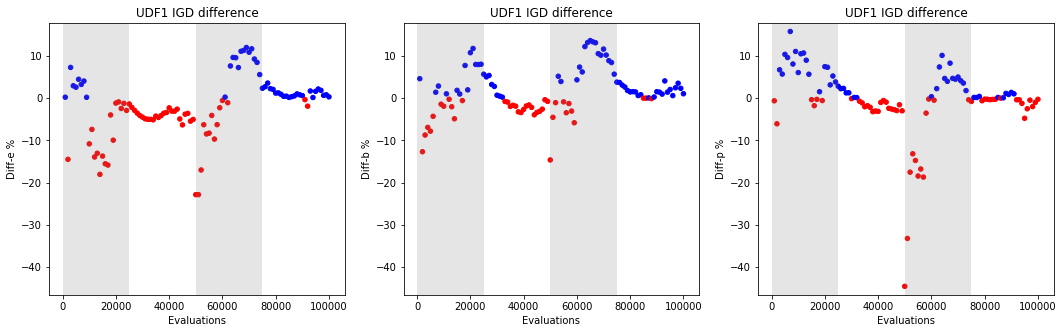

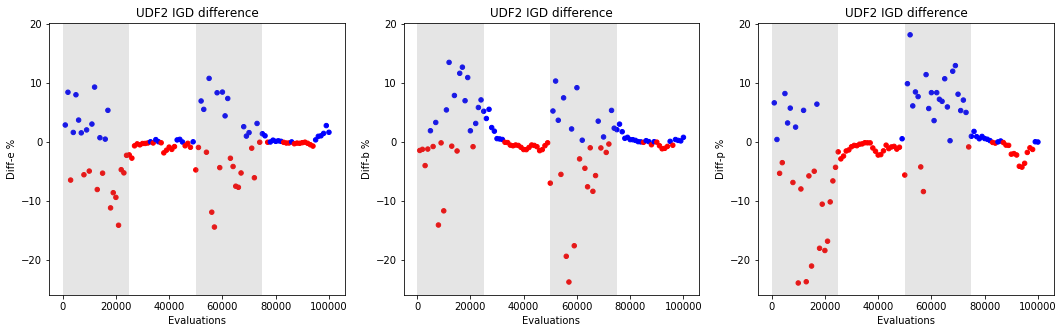

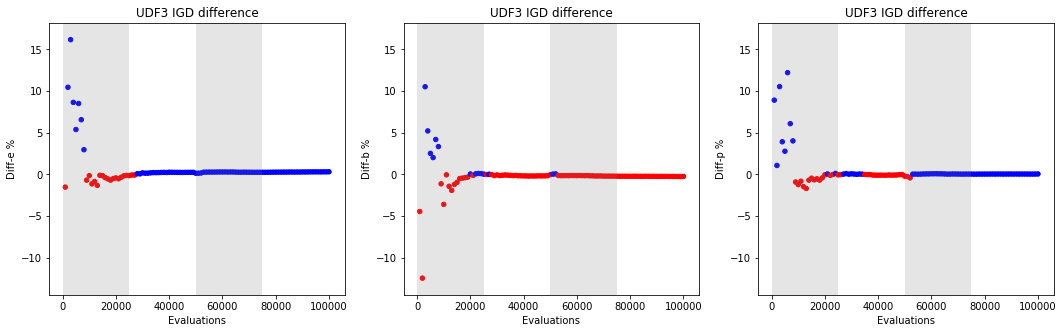

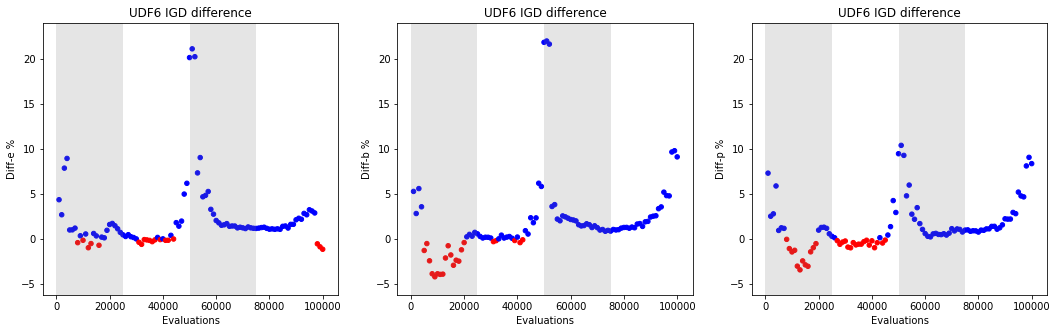

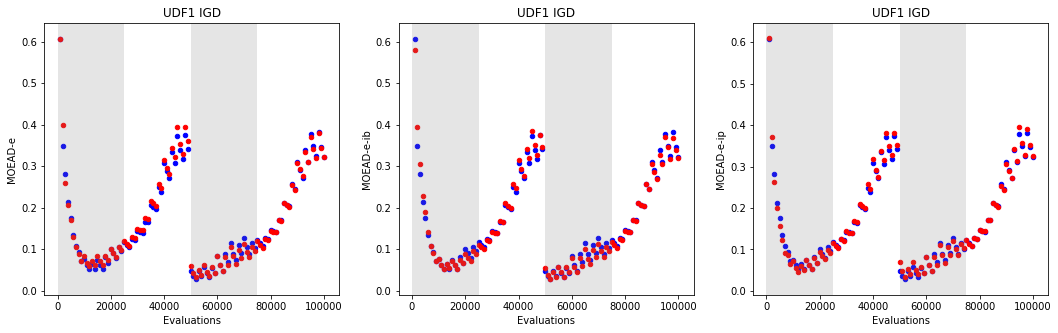

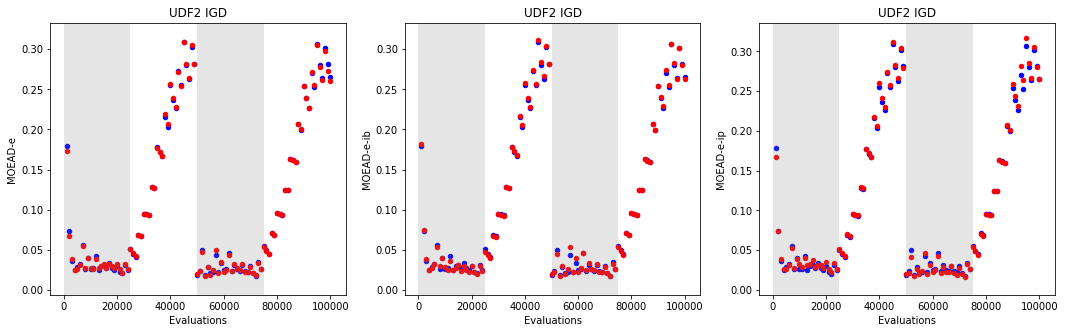

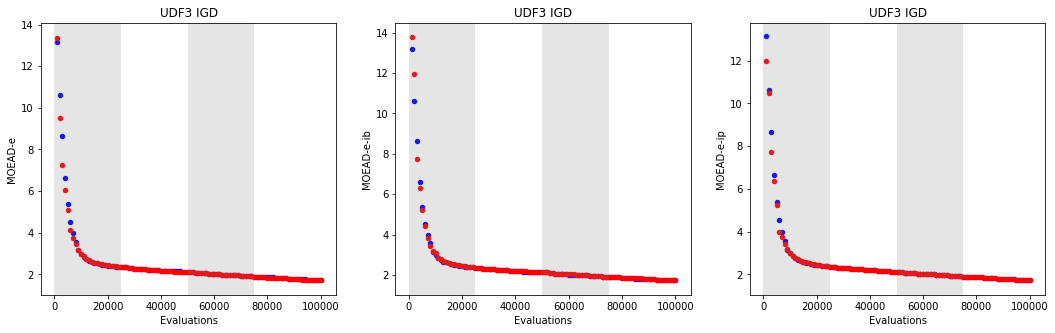

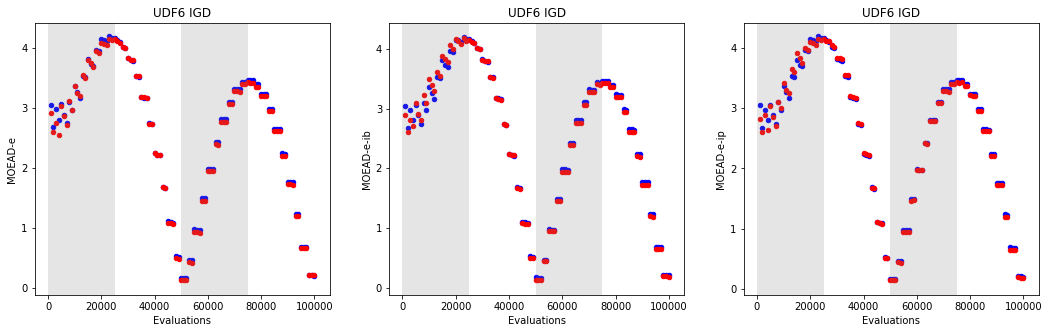

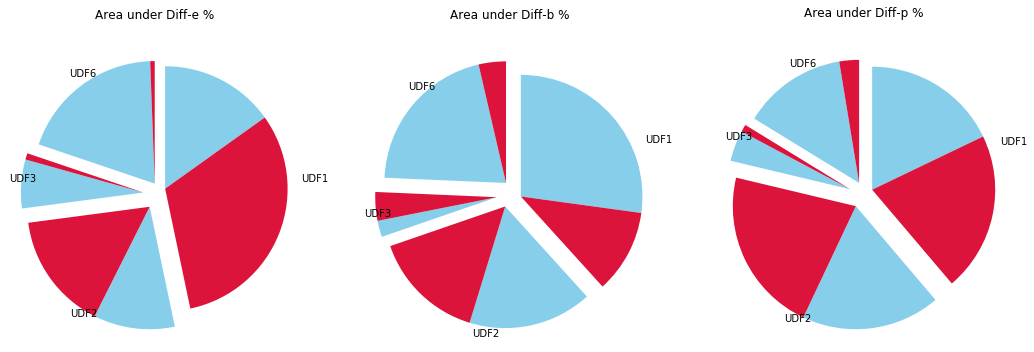

In [21]:
plot_all(igd_df, diagonal_shift)

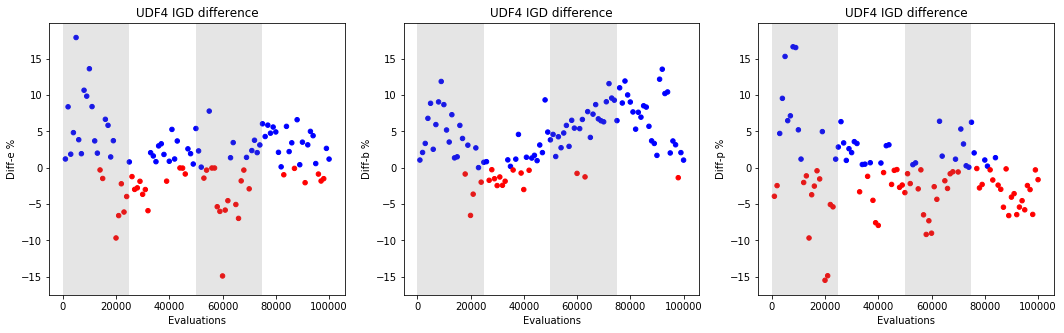

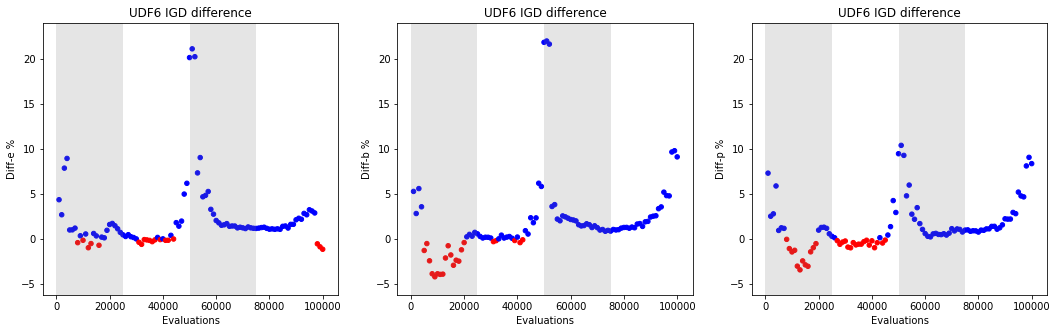

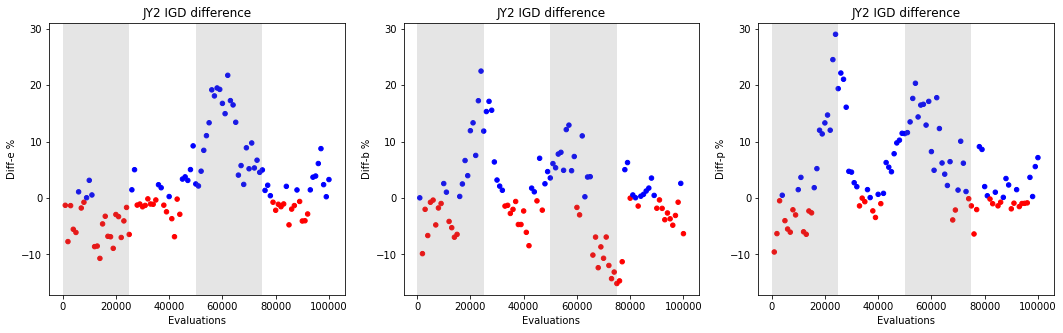

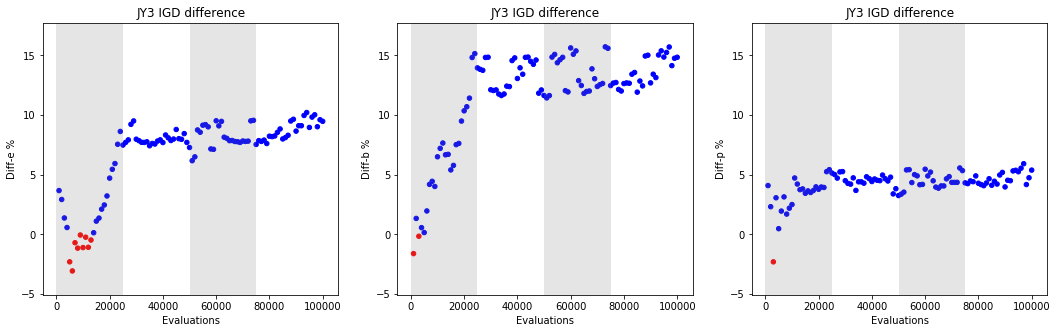

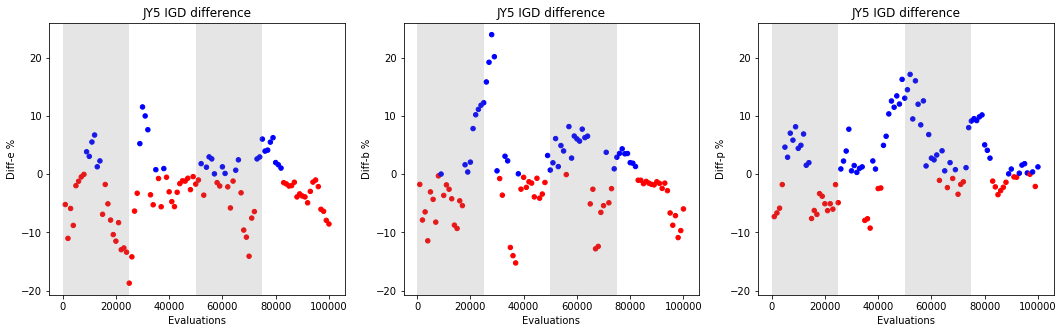

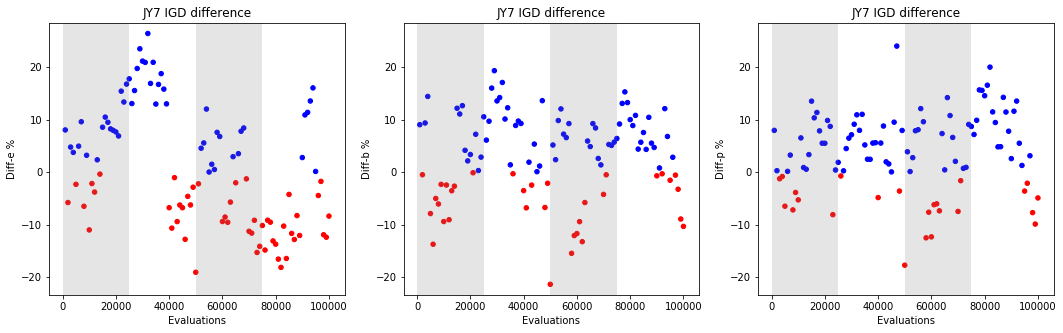

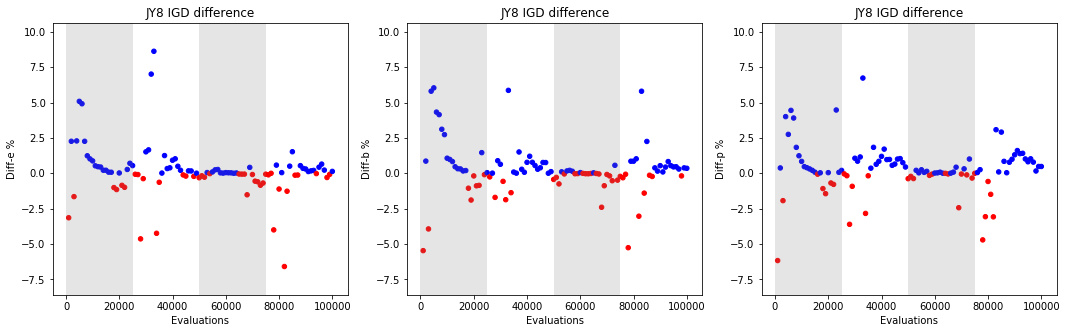

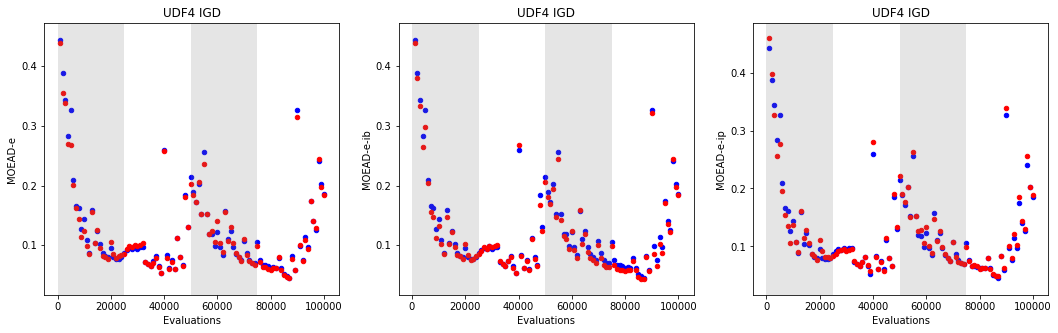

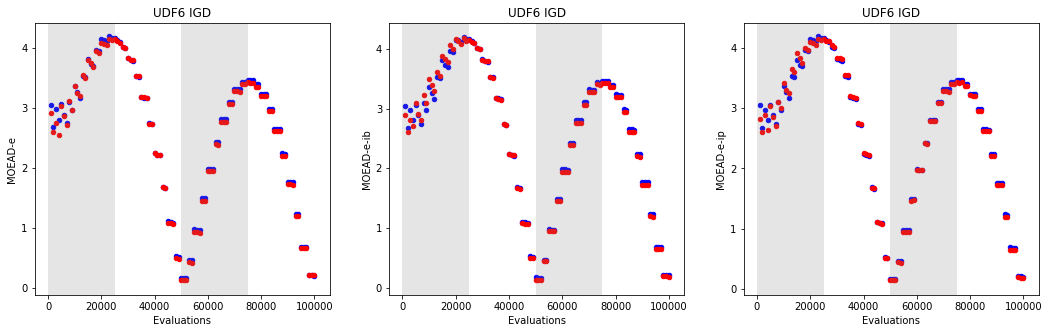

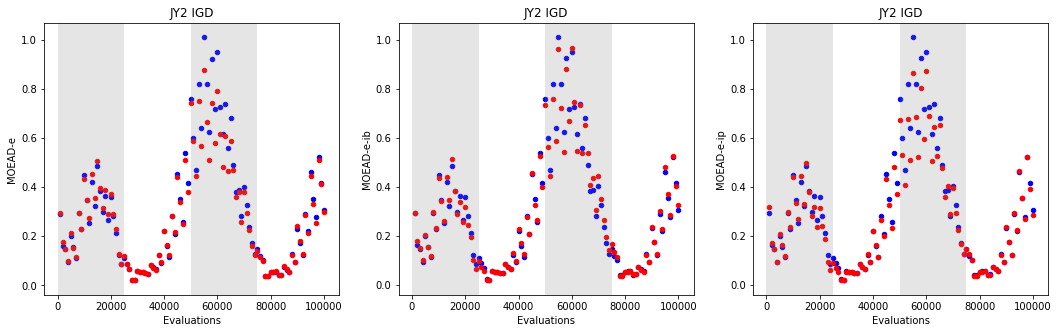

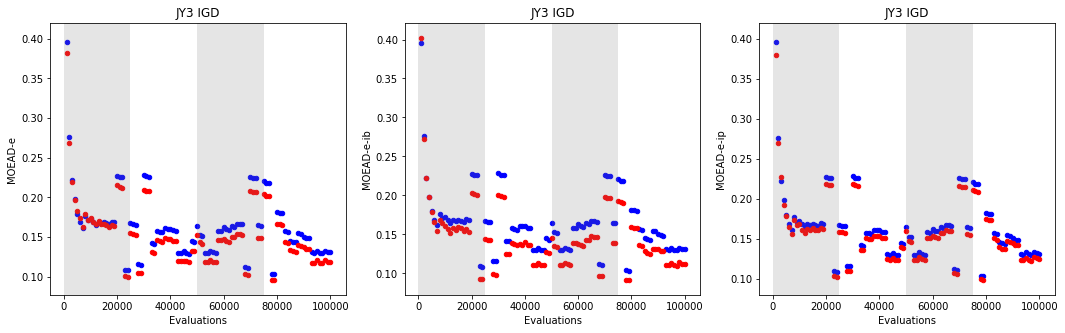

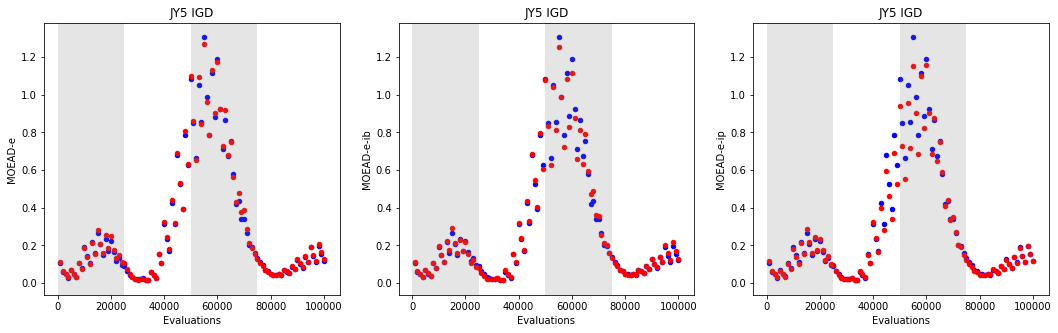

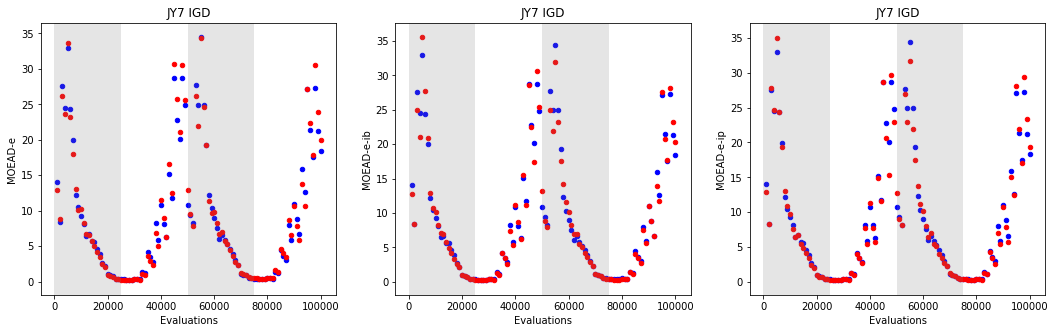

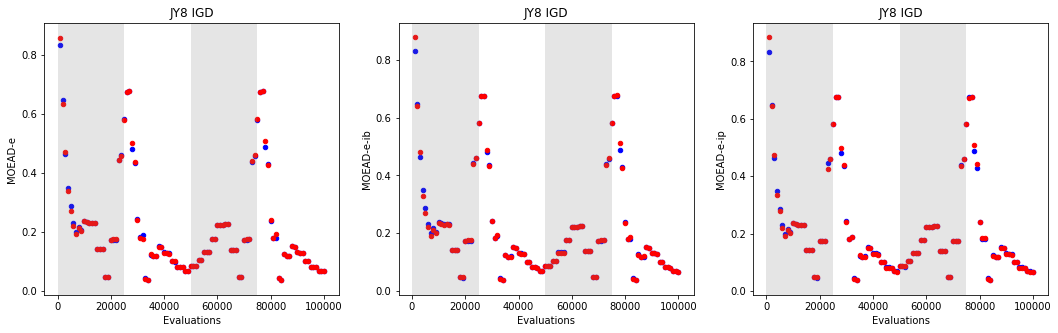

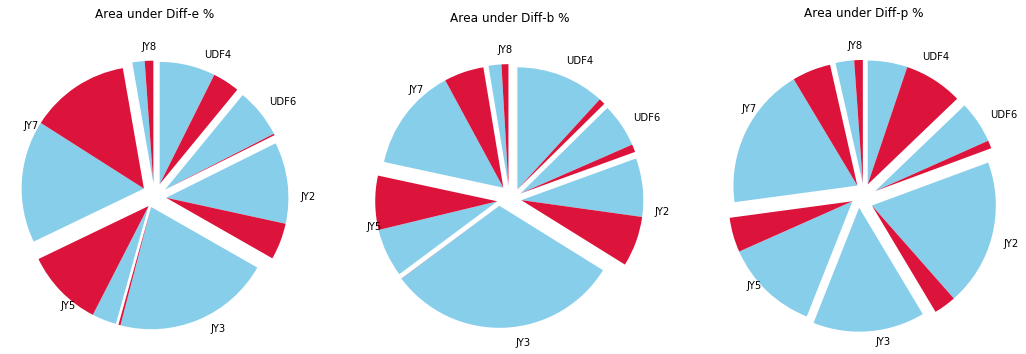

In [23]:
plot_all(igd_df, angular_shift)

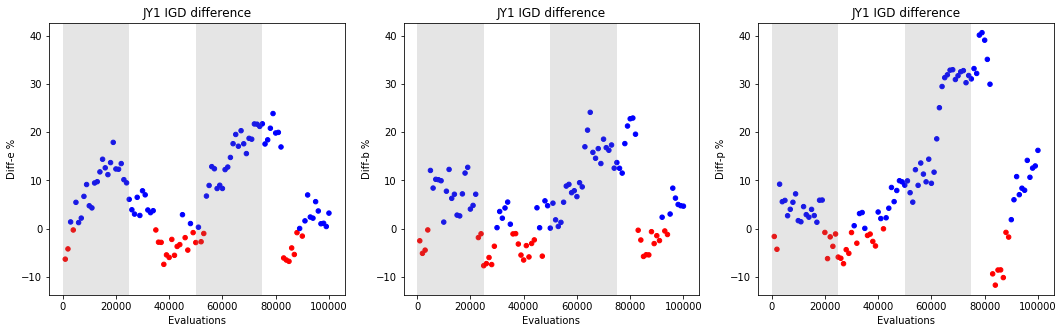

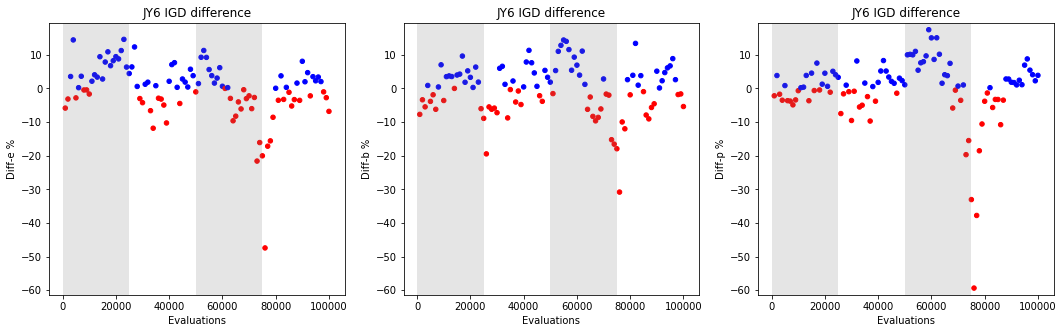

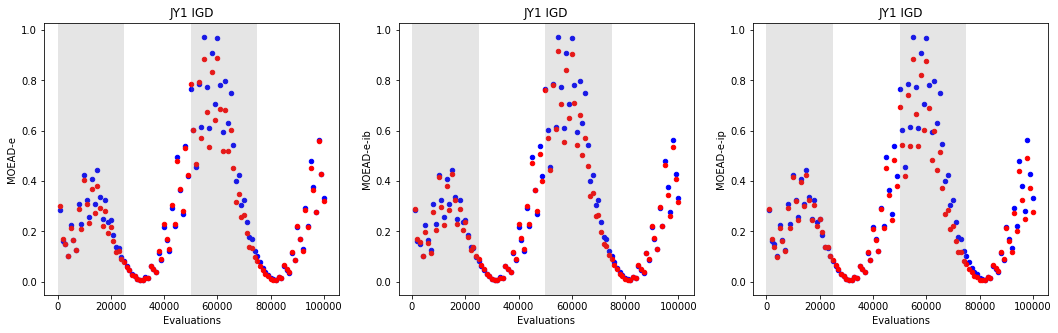

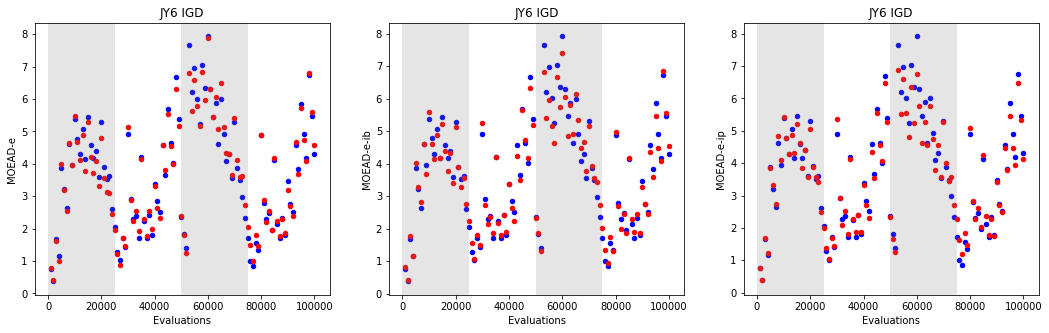

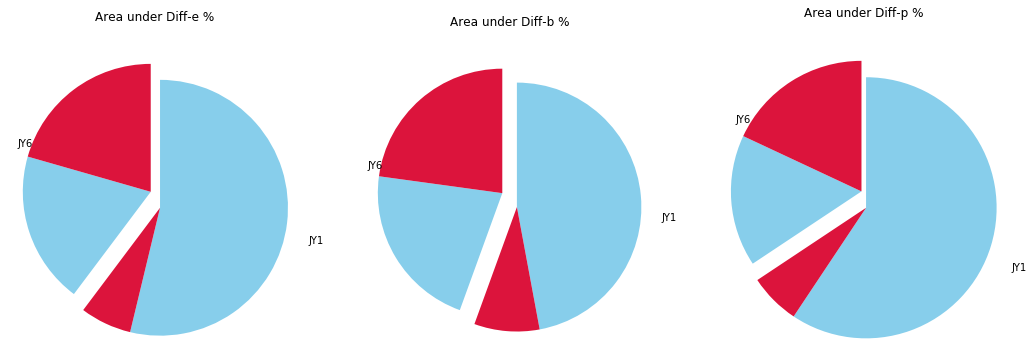

In [25]:
plot_all(igd_df, vertical_shift)

/Users/sizhe/Documents/cmlsga-jmetalpy/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


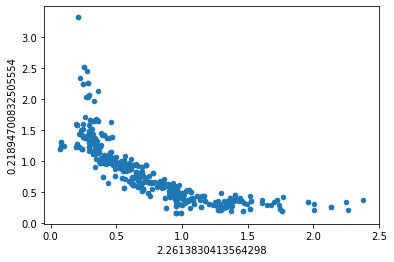

In [112]:
sols = pd.read_csv("data-500pop-100000evals-1runs-debug/MOEAD/UDF2/FUN.0.tsv.10000", delimiter="\ ")
sols.plot(x=0, y=1, kind="scatter")

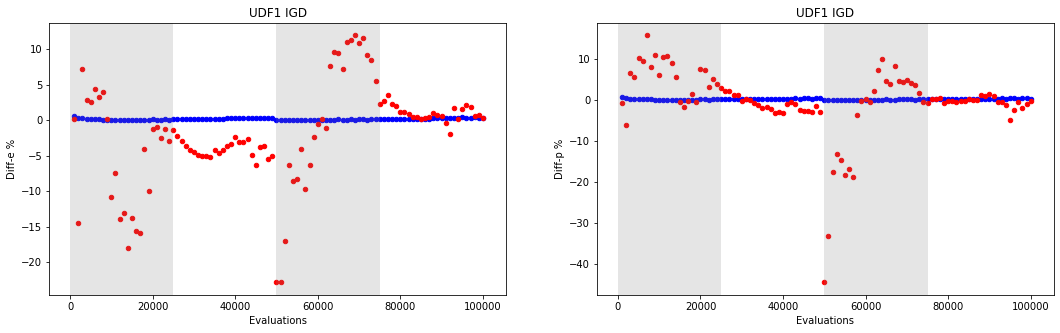

In [135]:
plot_scatter(igd_df, ["Diff-e %", "Diff-p %"], ["UDF1"])

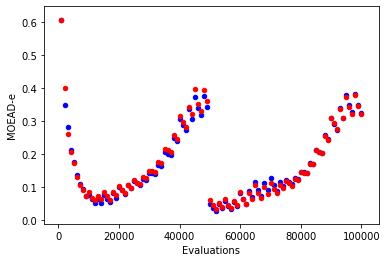

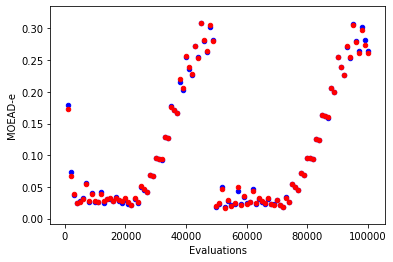

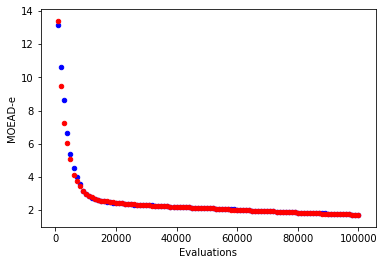

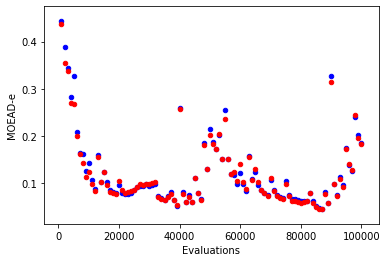

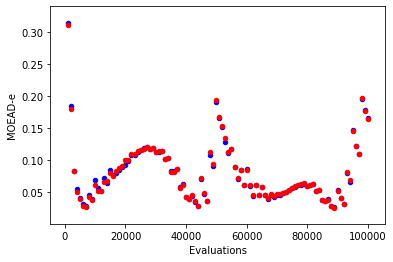

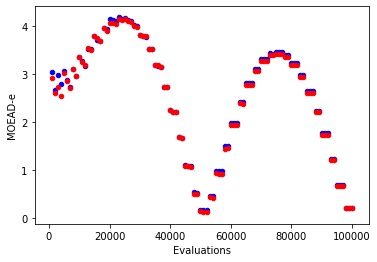

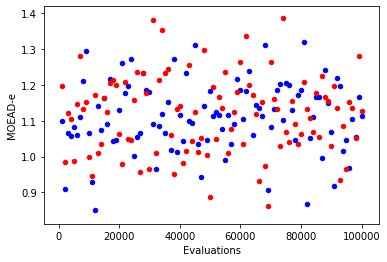

In [235]:
for p in igd_df["Problem"].unique():
    ax1 = igd_df[igd_df["Problem"] == p].plot(x="Evaluations", y="MOEAD", kind="scatter", color='b')
    ax2 = igd_df[igd_df["Problem"] == p].plot(x="Evaluations", y="MOEAD-e", kind="scatter", color='r', ax=ax1)

In [42]:
def write_igd_csv(filename, df, problems):
    with open('igd.csv', 'w+') as of:
            of.write('Algorithm,Problem,Evaluations,IGD-avg,IDG-std\n')

    for algorithm in ["MOEAD", "MOEAD-e"]:
        for problem in problems:
            for evals in range(1000, 100000, 1000):
                igd_df = df[(df["Problem"] == problem) 
                            & (df["Evaluations"] == evals) 
                            & (df["Algorithm"] == algorithm)]["IndicatorValue"]

                with open("igd.csv", "a+") as f:
                    f.write(",".join([algorithm, problem, str(evals), str(np.average(igd_df)), str(np.std(igd_df))]))
                    f.write("\n")

In [43]:
def write_raw_csv(filename, df, problems):
    with open(filename, "w+") as f:
        for algorithm in ["MOEAD", "MOEAD-e"]:
            for evals in range(1000, 101000, 1000):
                f.write(",".join([algorithm, str(evals)]))
                for problem in problems:
                    igd_df = df[(df["Problem"] == problem)
                                & (df["Algorithm"] == algorithm)
                                & (df["Evaluations"] == evals)]            

                    f.write(",{}".format(problem))
                    for i, row in igd_df.iterrows():
                        f.write(",{}".format(row["IndicatorValue"]))

                f.write("\n")

In [54]:
df_random_block = pd.read_csv("randomBlock1-10.csv")

In [53]:
df_random_proba = pd.read_csv("randomProba.csv")

In [56]:
df_random_block_var = pd.read_csv("randomBlock1-var2.csv")

In [58]:
problems = problems_udf + problems_jy
write_raw_csv("randomBlock1-10-raw.csv", df_random_block, problems)
write_raw_csv("randomBlock1-var2-raw.csv", df_random_block_var, problems)
write_raw_csv("randomProba-raw.csv", df_random_proba, problems)

In [65]:
def write_average_igd(filename, df, problems):
    with open(filename, "w+") as f:
        f.write(",".join(["Evaluations"] + problems))
        f.write("\n")
        for evals in range(1000, 101000, 1000):
            f.write("{}".format(evals))
            for problem in problems:
                igd_df = df[(df["Problem"] == problem)
                           & (df["Algorithm"] == "MOEAD-e")
                           & (df["Evaluations"] == evals)]
                f.write(",{}".format(np.average(igd_df["IndicatorValue"])))
            f.write("\n")

In [68]:
write_average_igd("average-igd.csv", df_random_block, problems)